In [80]:
import random
import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns
from statistics import mode
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
from scipy.stats import beta, norm, t, ttest_1samp

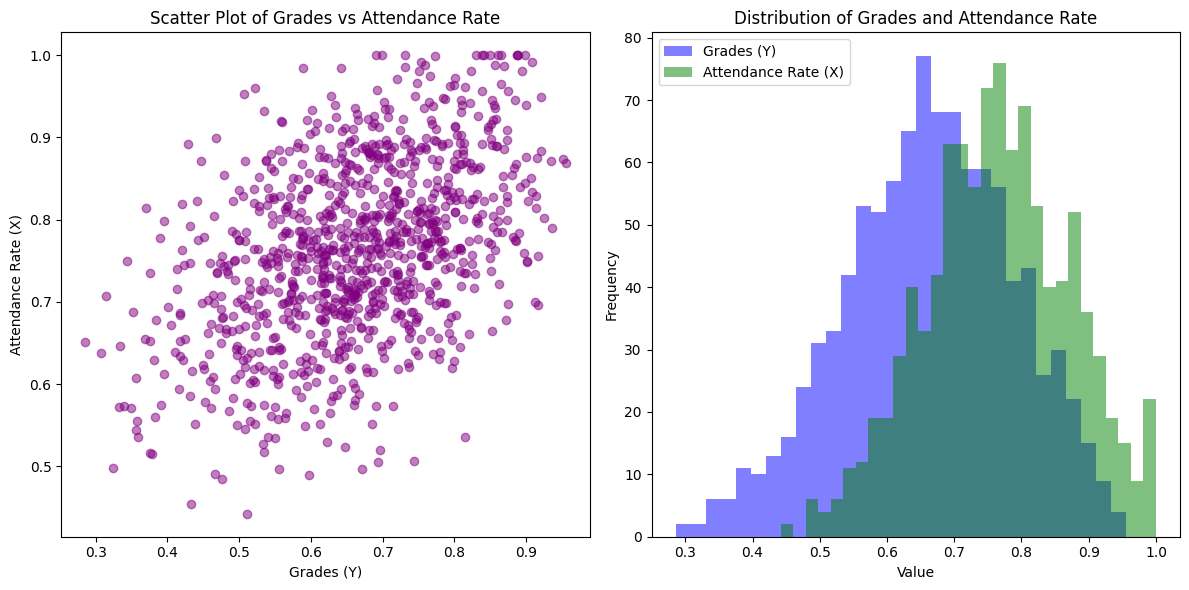

In [81]:
# Set the seed
np.random.seed(42)

# Generate grades (Y) from a beta distribution
x = np.linspace(0, 1, 1000)
grades = beta.rvs(8, 4, size=1000)

# Generate attendance rate (X) conditional on grades
attendance = np.clip([norm.rvs(loc=0.5 + 0.4 * grade, scale=0.1) for grade in grades], 0.3, 1)


# Scatter plot of Grades vs. Attendance Rate, to show the relationship
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(grades, attendance, alpha=0.5, color='purple')
plt.xlabel("Grades (Y)")
plt.ylabel("Attendance Rate (X)")
plt.title("Scatter Plot of Grades vs Attendance Rate")

# Show distribution
plt.subplot(1, 2, 2)
plt.hist(grades, bins=30, alpha=0.5, label="Grades (Y)", color='blue')
plt.hist(attendance, bins=30, alpha=0.5, label="Attendance Rate (X)", color='green')
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribution of Grades and Attendance Rate")
plt.legend()

plt.tight_layout()
plt.show()

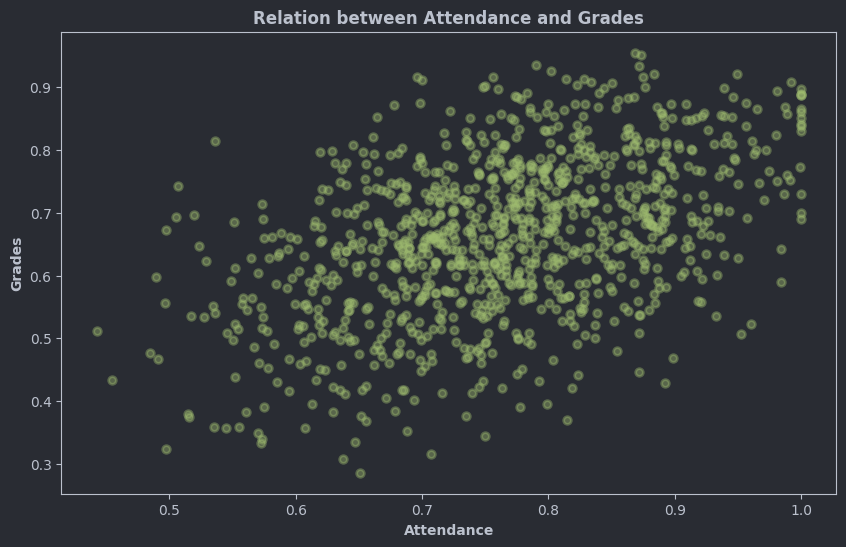

In [82]:
# Set background color for the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#292C33')
ax.set_facecolor('#292C33')
ax.scatter(attendance, grades, alpha=0.4, facecolor='#A0BD70', edgecolors='#A0BD70', linewidth=2, s=30)

# Customize axis lines and text
ax.spines['bottom'].set_color('#BBC1CD')  # Bottom axis color
ax.spines['left'].set_color('#BBC1CD')  # Left axis color
ax.spines['right'].set_color('#BBC1CD')  # Left axis color
ax.spines['top'].set_color('#BBC1CD')  # Left axis color
ax.tick_params(axis='x', colors='#BBC1CD')  # X-axis tick color
ax.tick_params(axis='y', colors='#BBC1CD')  # Y-axis tick color

# Labels and title
plt.xlabel('Attendance', color='#BBC1CD', fontweight='bold')
plt.ylabel('Grades', color='#BBC1CD', fontweight='bold')
plt.title('Relation between Attendance and Grades', color='#BBC1CD', fontweight='bold')

plt.savefig('simulated_data_scatter.svg', format='svg', dpi=1200)

plt.show()

In [83]:
# Simulate the actual data being used in the article
np.random.seed(seed=0)
grades = beta.rvs(8, 4, size=800)
attendance = np.clip([norm.rvs(loc=0.5 + 0.4 * grade, scale=0.1) for grade in grades], 0.3, 1)
df = pd.DataFrame.from_dict({'Grade': grades, 'Attendance': attendance})

# Estimate the actual data distribution and variance scaling factor
a_all, b_all, loc_all, scale_all = beta.fit(grades)

# Generate the MAR mechanism
mar = df.copy()
mar['Missing'] = [np.random.choice([1, 0], p=[min(1, attendance - 0.30), max(0,1 - attendance + 0.30),]) for attendance in df['Attendance']]

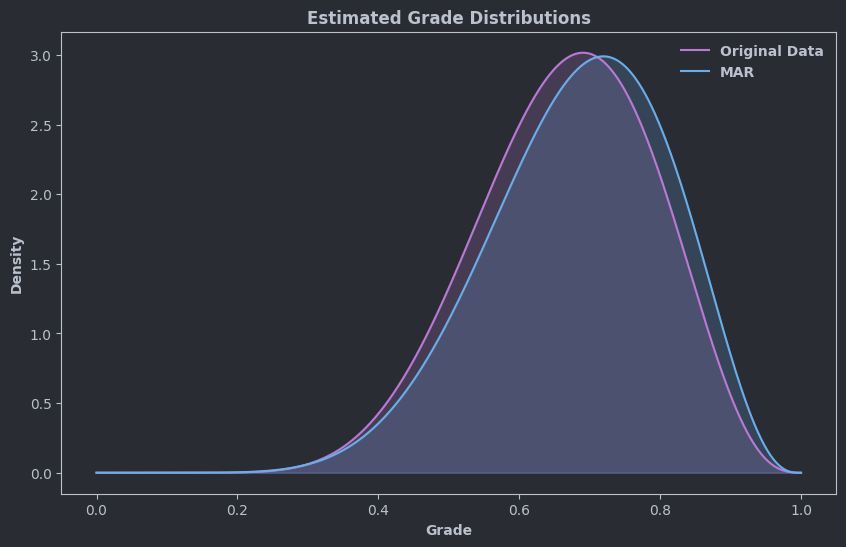

In [5]:
# Estimate the MAR distribution and variance scaling factor
mar_miss_rate = len(mar[mar['Missing'] == 1]) / len(mar)
a_mar, b_mar, loc_mar, scale_mar = beta.fit(mar[mar['Missing'] == 1]['Grade'])

# Set background color for the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#292C33')  # Background color for figure
ax.set_facecolor('#292C33')  # Background color for the plot area

# Plot the distributions
x = np.linspace(0, 1, 10_000)
actual = beta.pdf(x, a_all, b_all, loc_all, scale_all)
mar_pdf = beta.pdf(x, a_mar, b_mar, loc_mar, scale_mar)

# Actual data plotting
plt.plot(x, actual, color='#B979D5', label='Original Data')
plt.fill_between(x, actual, color='#B979D5', alpha=0.2)

# MAR Information and plotting
plt.plot(x, mar_pdf, color='#6AADE9', label='MAR')
plt.fill_between(x, mar_pdf, color='#6AADE9', alpha=0.2)

# Customize axis lines and text
ax.spines['bottom'].set_color('#BBC1CD')  # Bottom axis color
ax.spines['left'].set_color('#BBC1CD')  # Left axis color
ax.spines['right'].set_color('#BBC1CD')  # Left axis color
ax.spines['top'].set_color('#BBC1CD')  # Left axis color
ax.tick_params(axis='x', colors='#BBC1CD')  # X-axis tick color
ax.tick_params(axis='y', colors='#BBC1CD')  # Y-axis tick color

# Labels and title
plt.xlabel('Grade', color='#BBC1CD', fontweight='bold')
plt.ylabel('Density', color='#BBC1CD', fontweight='bold')
plt.title('Estimated Grade Distributions', color='#BBC1CD', fontweight='bold')

# Add a legend
legend = ax.legend(facecolor='#292C33', framealpha=0, edgecolor='#000000', prop={'weight': 'bold'})

# Change legend text color
for text in legend.get_texts():
    text.set_color('#BBC1CD')  # Set the legend text color to black

plt.savefig('Grade_MCAR_and_MAR_distribution_plot.svg', format='svg', dpi=1200)

plt.show()

# MAR

In [26]:
model_data = mar.sort_values(by='Missing')
model_data['Intercept'] = 1

# Prepare Stan Data
N_obs = len(model_data[model_data['Missing'] == 0])
N_mis = len(model_data[model_data['Missing'] == 1])
X = model_data[['Intercept', 'Attendance']].to_numpy()
Y_obs = model_data[model_data['Missing'] == 0]['Grade'].tolist()
obs_idx = list(range(1, N_obs+1))
mis_idx = list(range(N_obs+1, N_mis+N_obs+1))

stan_data = {
    'N_obs': N_obs,
    'N_mis': N_mis,
    'N_total': N_obs + N_mis,
    'K': X.shape[1],
    'X': X,
    'Y_obs': Y_obs,
    'obs_idx': obs_idx,
    'mis_idx': mis_idx
}

In [38]:
# Compile and sample
model = CmdStanModel(stan_file='mar.stan')
fit = model.sample(data=stan_data, chains=4, iter_sampling=2000, iter_warmup=1000)

15:07:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                                                                                                                    | 00:00 Status
chain 2 |                                                                                                                                                                                    | 00:00 Status

chain 3 |                                                                                                                                                                                    | 00:00 Status


chain 1 |█████████▏                                                                                                                                         | 00:00 Iteration:    1 / 3000 [  0%]  (Warmup)


chain 4 |█████████▏                                                                                                         


15:07:19 - cmdstanpy - INFO - CmdStan done processing.
15:07:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'mar.stan', line 29, column 4 to column 60)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'mar.stan', line 29, column 4 to column 60)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'mar.stan', line 29, column 4 to column 60)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'mar.stan', line 25, column 2 to column 22)
	Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'mar.stan', line 29, column 4 to column 60)
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'mar.stan', line 29, column 4 to column 60)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'mar.stan', line 29, colum

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

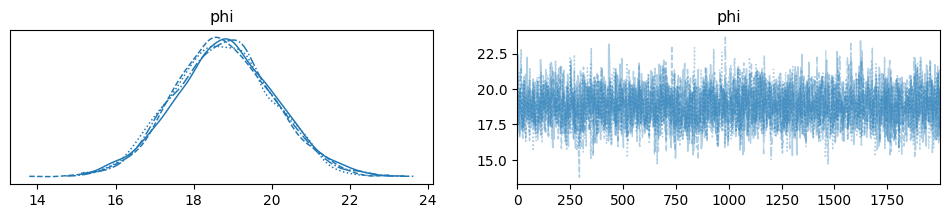

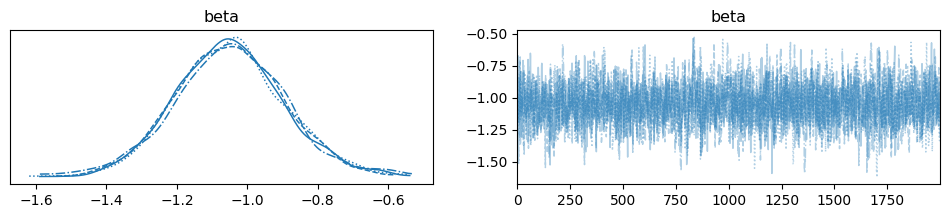

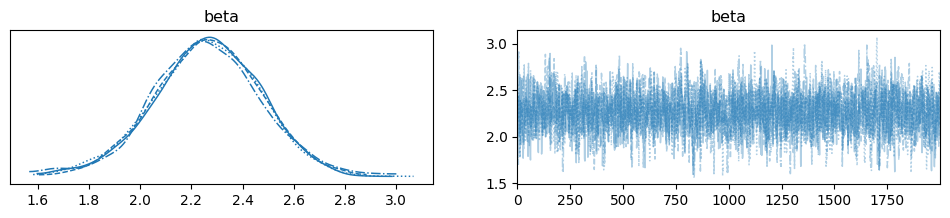

In [39]:
idata = az.from_cmdstanpy(posterior=fit, posterior_predictive=["Y_mis"])
az.plot_trace(idata, var_names=["phi"])
az.plot_trace(idata, var_names=["beta"], coords={"beta_dim_0": [0]})
az.plot_trace(idata, var_names=["beta"], coords={"beta_dim_0": [1]})

array([[<Axes: title={'center': 'Y_mis\n0'}>,
        <Axes: title={'center': 'Y_mis\n1'}>,
        <Axes: title={'center': 'Y_mis\n2'}>],
       [<Axes: title={'center': 'Y_mis\n3'}>,
        <Axes: title={'center': 'Y_mis\n4'}>, <Axes: >]], dtype=object)

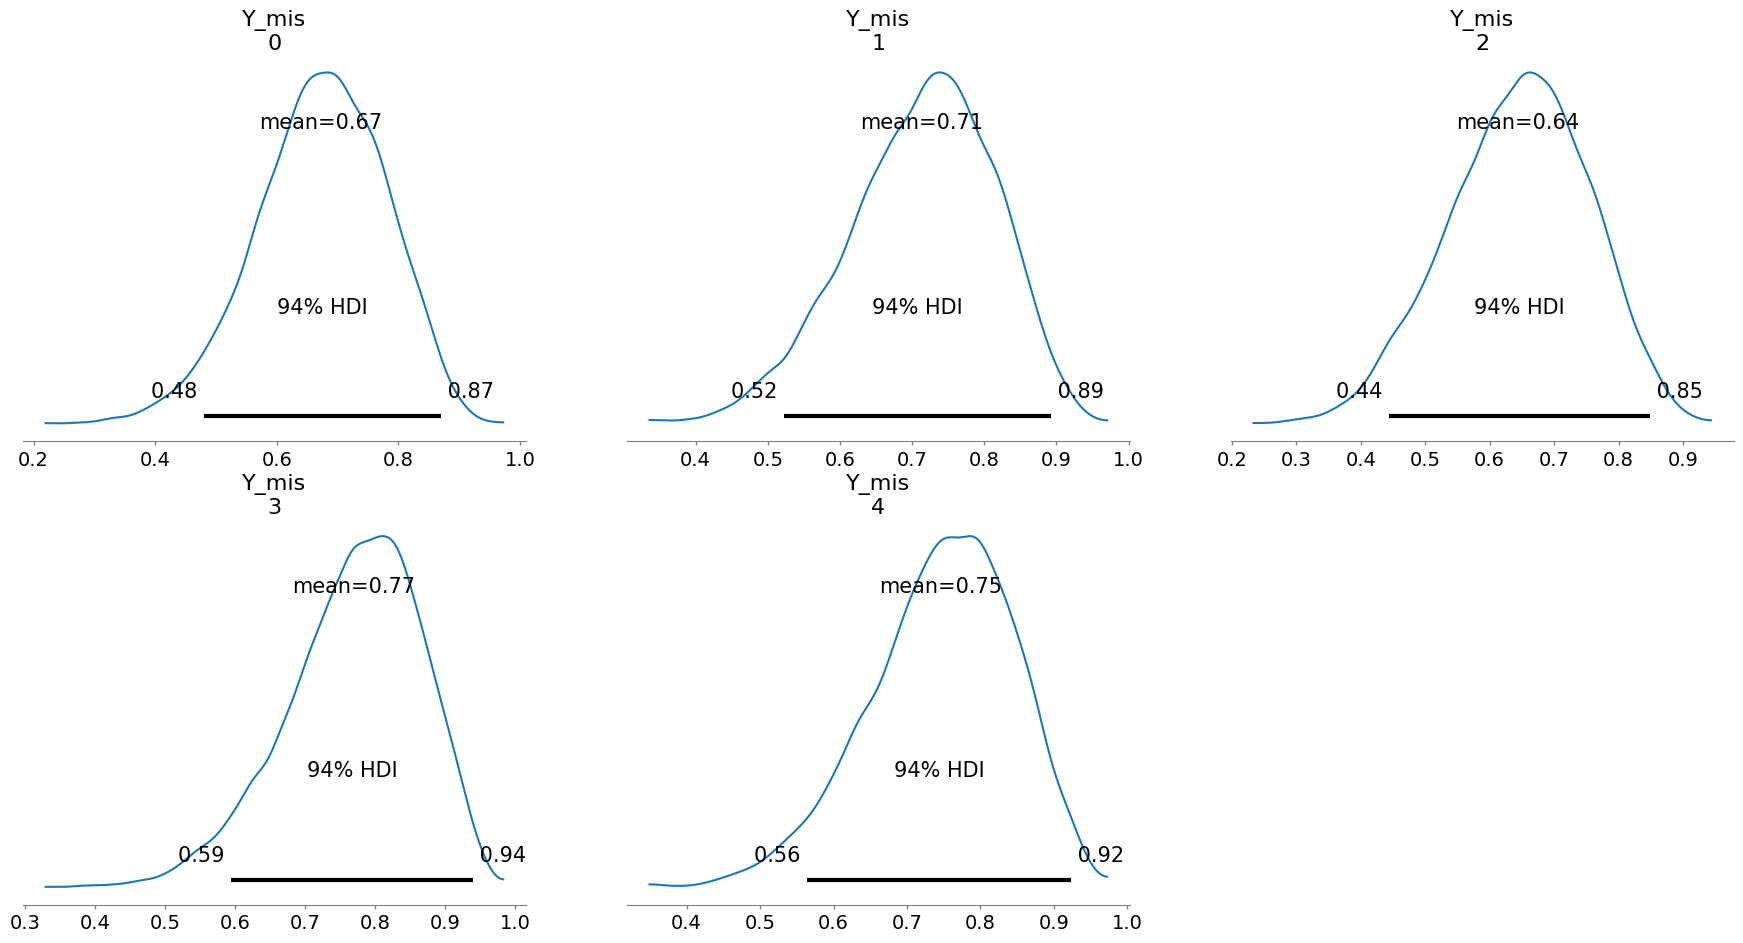

In [40]:
az.plot_posterior(idata.posterior_predictive, var_names=["Y_mis"], coords={"Y_mis_dim_0": slice(0, 4)})

In [71]:
D, dfs = 100, []
mis_idx2 = model_data[model_data['Missing'] == 1].index
y_mis_samples = idata.posterior_predictive["Y_mis"].stack(sample=("chain", "draw")).values

rng = np.random.default_rng(seed=123)
n_samples = y_mis_samples.shape[1]

for _ in range(0, D):
    rand_idx = rng.integers(low=0, high=n_samples, size=y_mis_samples.shape[0])
    y_mis_draw = y_mis_samples[np.arange(y_mis_samples.shape[0]), rand_idx]
    new_df = model_data.copy()
    new_df.loc[mis_idx2, 'Grade'] = y_mis_draw
    dfs.append(new_df)

In [72]:
means = []
variances = []

for df in dfs:
    y = df['Grade'].values
    means.append(np.mean(y))
    variances.append(np.var(y, ddof=1) / len(y))

Q_bar = np.mean(means)
U_bar = np.mean(variances)
B = np.var(means, ddof=1)
T = U_bar + (1 + 1/D) * B

# Step 3: Degrees of freedom
df_denom = ((1 + 1/D) * B)
df = (D - 1) * (1 + U_bar / df_denom) ** 2

# Step 4: 95% Confidence Interval
alpha = 0.05
t_crit = t.ppf(1 - alpha / 2, df)   # force scalar
ci_lower = Q_bar - t_crit * np.sqrt(T)
ci_upper = Q_bar + t_crit * np.sqrt(T)

print(f"Combined Mean Estimate: {Q_bar:.4f}")
print(f"95% CI: ({ci_lower:.4f}, {ci_upper:.4f})")

Combined Mean Estimate: 0.6604
95% CI: (0.6507, 0.6701)


In [73]:
x = mar[mar['Missing'] == 0]['Grade'].values
n = len(x)
mar_mean = np.mean(x)
mar_se = np.std(x, ddof=1) / np.sqrt(n)
t_crit = t.ppf(1 - alpha / 2, df=n - 1)

ci_lower = mar_mean - t_crit * mar_se
ci_upper = mar_mean + t_crit * mar_se
print(f'Mean: {mar_mean:.4f} CI L: {ci_lower:.4f} CI U: {ci_upper:.4f})')

Mean: 0.6475 CI L: 0.6358 CI U: 0.6592)


In [74]:
x = mar['Grade'].values
n = len(x)
mean = np.mean(x)
se = np.std(x, ddof=1) / np.sqrt(n)
t_crit = t.ppf(1 - alpha / 2, df=n - 1)

ci_lower = mean - t_crit * se
ci_upper = mean + t_crit * se
print(f'Mean: {mean:.4f} CI L: {ci_lower:.4f} CI U: {ci_upper:.4f})')

Mean: 0.6655 CI L: 0.6568 CI U: 0.6742)


In [75]:
print(f'MAR Difference: {mean - mar_mean:.3f} \t Relative Difference: {(mean - mar_mean) / mean:.3f}')
_, p_value = ttest_1samp(mar[mar['Missing'] == 0]['Grade'].values, popmean=mean)
print(f"MAR p-value = {p_value:.3f}\n")

print(f'MI Difference: {mean - Q_bar:.3f} \t Relative Difference: {(mean - Q_bar) / mean:.3f}')
t_stat = (Q_bar - mean) / np.sqrt(T)
p_value = 2 * t.sf(np.abs(t_stat), df)
print(f"MI p-value: {p_value:.3f}")

MAR Difference: 0.018 	 Relative Difference: 0.027
MAR p-value = 0.003

MI Difference: 0.005 	 Relative Difference: 0.008
MI p-value: 0.303


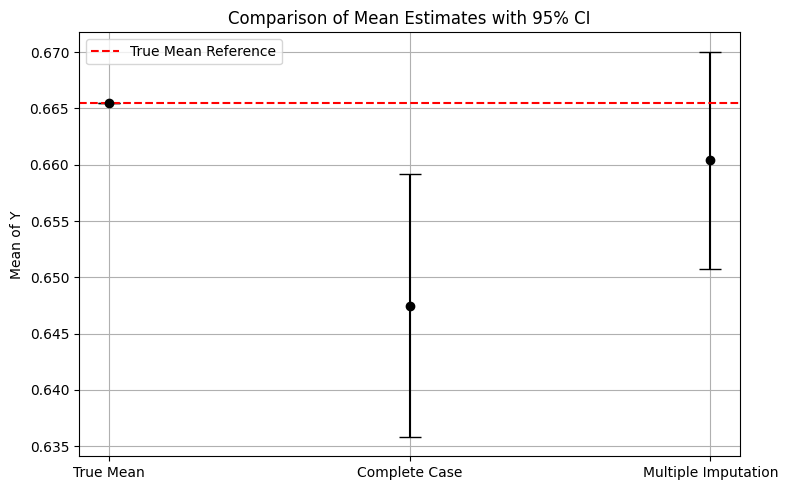

In [58]:
ci_cc = 1.96 * mar_se  # Approximate 95% CI for CC
ci_mi = 1.96 * np.sqrt(T)  # Approximate CI for MI (or use t-crit with df)

means = [mean, mar_mean, Q_bar]
errors = [0, ci_cc, ci_mi]  # no error for true mean

labels = ['True Mean', 'Complete Case', 'Multiple Imputation']

plt.figure(figsize=(8, 5))
plt.errorbar(x=labels, y=means, yerr=errors, fmt='o', capsize=8, color='black')
plt.axhline(mean, linestyle='--', color='red', label='True Mean Reference')
plt.ylabel("Mean of Y")
plt.title("Comparison of Mean Estimates with 95% CI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [77]:
# Let's say you bootstrapped these or computed them:
n_samples = len(means)  # same number as MI draws for fair comparison
means_cc = np.random.normal(loc=mar_mean, scale=mar_se, size=n_samples)

df_density = pd.DataFrame({
    'Mean': list(means) + list(means_cc),
    'Source': ['MI'] * len(means) + ['CC'] * len(means)
})

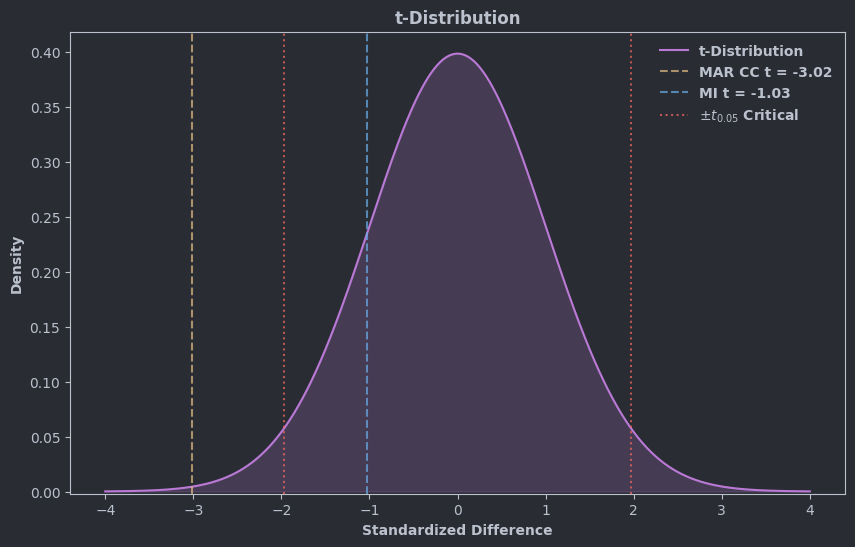

In [78]:
# Differences and t-scores
delta_cc = mar_mean - mean
delta_mi = Q_bar - mean

alpha = 0.05
t_crit_cc = t.ppf(1 - alpha/2, df=len(mar[mar['Missing'] == 0]) - 1)
t_cc = delta_cc / mar_se
t_mi = delta_mi / np.sqrt(T)

pdf_cc = t.pdf(x, len(mar[mar['Missing'] == 0]) - 1)
pdf_mi = t.pdf(x, df)

# Set background color for the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#292C33')  # Background color for figure
ax.set_facecolor('#292C33')  # Background color for the plot area

# Actual data plotting
x = np.linspace(-4, 4, 1000)
plt.plot(x, pdf_cc, color='#B979D5', label='t-Distribution')
plt.fill_between(x, pdf_cc, color='#B979D5', alpha=0.2)

# Add vertical lines for actual t-values
plt.axvline(t_cc, linestyle='--', color='#E4BE83', alpha=0.7, label=f'MAR CC t = {t_cc:.2f}')
plt.axvline(t_mi, linestyle='--', color='#6AADE9', alpha=0.7, label=f'MI t = {t_mi:.2f}')

plt.axvline(t_crit_cc, color='#FF6961', linestyle=':', alpha=0.7, label=r'$\pm t_{0.05}$ Critical')
plt.axvline(-t_crit_cc, color='#FF6961', linestyle=':', alpha=0.7)

# Customize axis lines and text
ax.spines['bottom'].set_color('#BBC1CD')  # Bottom axis color
ax.spines['left'].set_color('#BBC1CD')  # Left axis color
ax.spines['right'].set_color('#BBC1CD')  # Left axis color
ax.spines['top'].set_color('#BBC1CD')  # Left axis color
ax.tick_params(axis='x', colors='#BBC1CD')  # X-axis tick color
ax.tick_params(axis='y', colors='#BBC1CD')  # Y-axis tick color

# Labels and title
plt.xlabel('Standardized Difference', color='#BBC1CD', fontweight='bold')
plt.ylabel('Density', color='#BBC1CD', fontweight='bold')
plt.title('t-Distribution', color='#BBC1CD', fontweight='bold')

# Add a legend
legend = ax.legend(facecolor='#292C33', framealpha=0, edgecolor='#000000', prop={'weight': 'bold'})
ax.set_ylim(bottom=-0.002)

# Change legend text color
for text in legend.get_texts():
    text.set_color('#BBC1CD')  # Set the legend text color to black

plt.savefig('Grade_MAR_CC_MI_t-distribution_plot.svg', format='svg', dpi=1200)

plt.show()

# MNAR

In [84]:
mnar = df.copy()
mnar['Missing'] = [np.random.choice([1, 0], p=[min(1, grade - 0.25), max(0,1 - grade + 0.25),]) for grade in df['Grade']]
mnar

,Grade,Attendance,Missing
0,0.752745,0.767822,1
1,0.870505,0.827801,1
2,0.620807,0.679221,0
3,0.718636,0.566904,1
4,0.673572,0.814216,1
...,...,...,...
795,0.684219,0.726455,0
796,0.754452,0.812645,1
797,0.694568,0.844661,1
798,0.640734,0.660976,1


/Users/tomas/.pyenv/versions/3.10.14/envs/missing-data/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


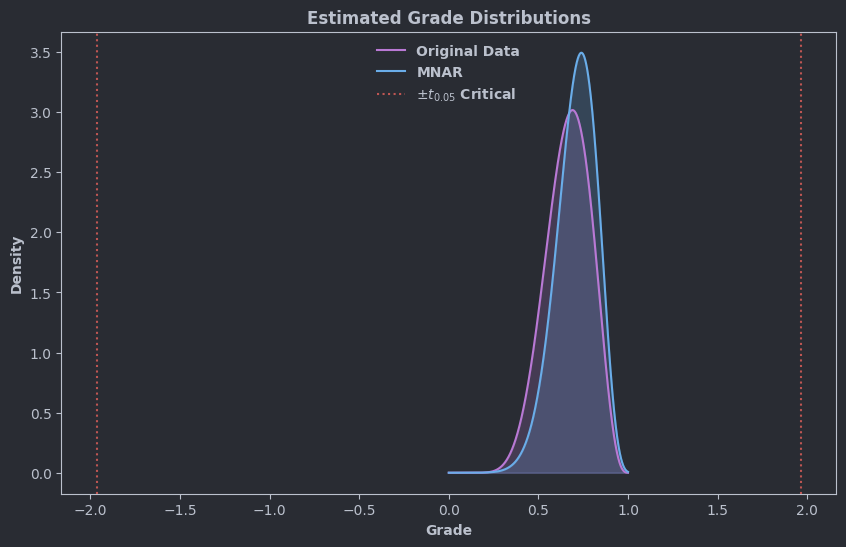

In [85]:
# Estimate the MAR distribution and variance scaling factor
mnar_miss_rate = len(mnar[mnar['Missing'] == 1]) / len(mnar)
a_mnar, b_mnar, loc_mnar, scale_mnar = beta.fit(mnar[mnar['Missing'] == 1]['Grade'])

# Set background color for the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#292C33')  # Background color for figure
ax.set_facecolor('#292C33')  # Background color for the plot area

# Plot the distributions
x = np.linspace(0, 1, 10_000)
actual = beta.pdf(x, a_all, b_all, loc_all, scale_all)
mnar_pdf = beta.pdf(x, a_mnar, b_mnar, loc_mnar, scale_mnar)

# Actual data plotting
plt.plot(x, actual, color='#B979D5', label='Original Data')
plt.fill_between(x, actual, color='#B979D5', alpha=0.2)

# MAR Information and plotting
plt.plot(x, mnar_pdf, color='#6AADE9', label='MNAR')
plt.fill_between(x, mnar_pdf, color='#6AADE9', alpha=0.2)

# Customize axis lines and text
ax.spines['bottom'].set_color('#BBC1CD')  # Bottom axis color
ax.spines['left'].set_color('#BBC1CD')  # Left axis color
ax.spines['right'].set_color('#BBC1CD')  # Left axis color
ax.spines['top'].set_color('#BBC1CD')  # Left axis color
ax.tick_params(axis='x', colors='#BBC1CD')  # X-axis tick color
ax.tick_params(axis='y', colors='#BBC1CD')  # Y-axis tick color

# Labels and title
plt.xlabel('Grade', color='#BBC1CD', fontweight='bold')
plt.ylabel('Density', color='#BBC1CD', fontweight='bold')
plt.title('Estimated Grade Distributions', color='#BBC1CD', fontweight='bold')

# Add a legend
legend = ax.legend(facecolor='#292C33', framealpha=0, edgecolor='#000000', prop={'weight': 'bold'})

# Change legend text color
for text in legend.get_texts():
    text.set_color('#BBC1CD')  # Set the legend text color to black

plt.savefig('Grade_MCAR_and_MAR_distribution_plot.svg', format='svg', dpi=1200)

plt.show()

In [86]:
model_data = mnar.sort_values(by='Missing')
model_data['Intercept'] = 1

# Prepare Stan Data
N_obs = len(model_data[model_data['Missing'] == 0])
N_mis = len(model_data[model_data['Missing'] == 1])
X = model_data[['Intercept', 'Attendance']].to_numpy()
Y_obs = model_data[model_data['Missing'] == 0]['Grade'].tolist()
M = model_data['Missing'].tolist()

stan_data = {
    'N_obs': N_obs,
    'N_mis': N_mis,
    'N_total': N_obs + N_mis,
    'K': X.shape[1],
    'X': X,
    'Y_obs': Y_obs,
    'M': M
}

In [87]:
# Compile and sample
model = CmdStanModel(stan_file='mnar.stan')
fit = model.sample(data=stan_data, chains=4, iter_sampling=2500, iter_warmup=1500)

15:14:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                                                                                                                    | 00:00 Status
chain 2 |                                                                                                                                                                                    | 00:00 Status

chain 3 |                                                                                                                                                                                    | 00:00 Status


chain 4 |                                                                                                                                                                                    | 00:00 Status


chain 4 |███████                                                                                                            


15:15:32 - cmdstanpy - INFO - CmdStan done processing.
15:15:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'mnar.stan', line 45, column 4 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'mnar.stan', line 45, column 4 to column 48)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'mnar.stan', line 45, column 4 to column 48)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'mnar.stan', line 22, column 2 to column 22)
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'mnar.stan', line 22, column 2 to column 22)
	Exception: beta_lpdf: Second shape parameter is 0, but must be positive finite! (in 'mnar.stan', line 45, column 4 to column 48)
Exception: beta_lpdf: First shape parameter is 0, but must be positive finite! (in 'mnar.stan', line 45, col

array([[<Axes: title={'center': 'alpha1'}>,
        <Axes: title={'center': 'alpha1'}>]], dtype=object)

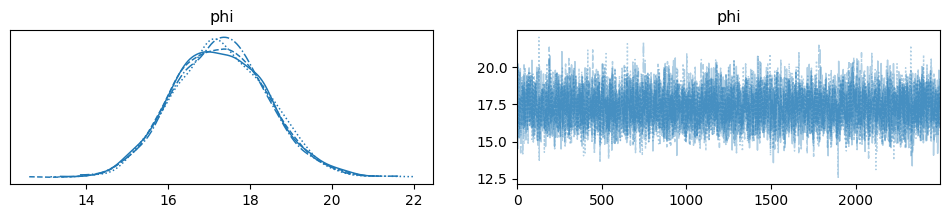

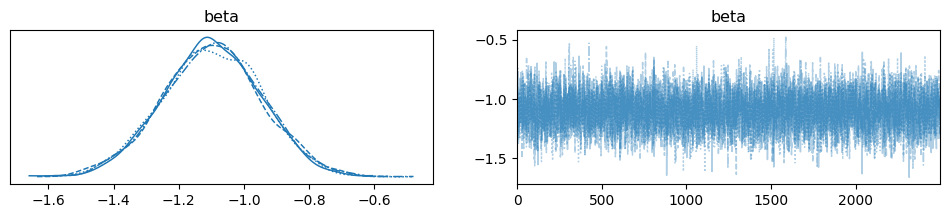

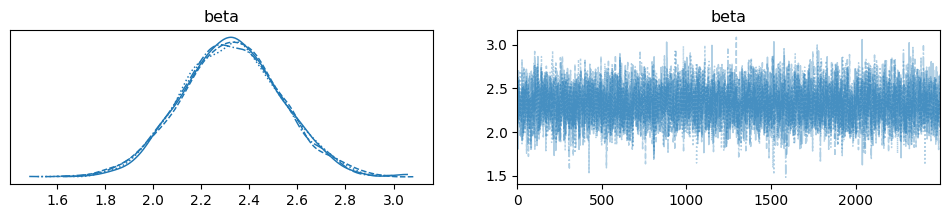

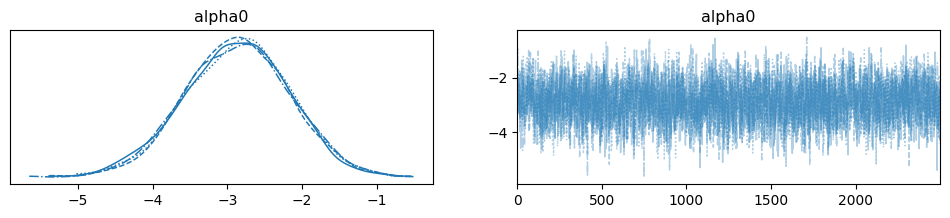

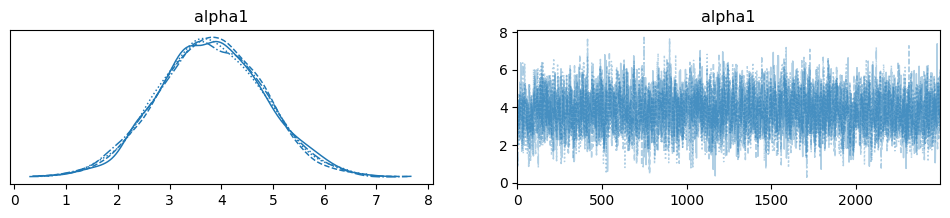

In [88]:
idata = az.from_cmdstanpy(posterior=fit, posterior_predictive=["Y_mis_draw"])
az.plot_trace(idata, var_names=["phi"])
az.plot_trace(idata, var_names=["beta"], coords={"beta_dim_0": [0]})
az.plot_trace(idata, var_names=["beta"], coords={"beta_dim_0": [1]})
az.plot_trace(idata, var_names=["alpha0"])
az.plot_trace(idata, var_names=["alpha1"])

array([[<Axes: title={'center': 'Y_mis_draw\n0'}>,
        <Axes: title={'center': 'Y_mis_draw\n1'}>,
        <Axes: title={'center': 'Y_mis_draw\n2'}>],
       [<Axes: title={'center': 'Y_mis_draw\n3'}>,
        <Axes: title={'center': 'Y_mis_draw\n4'}>, <Axes: >]],
      dtype=object)

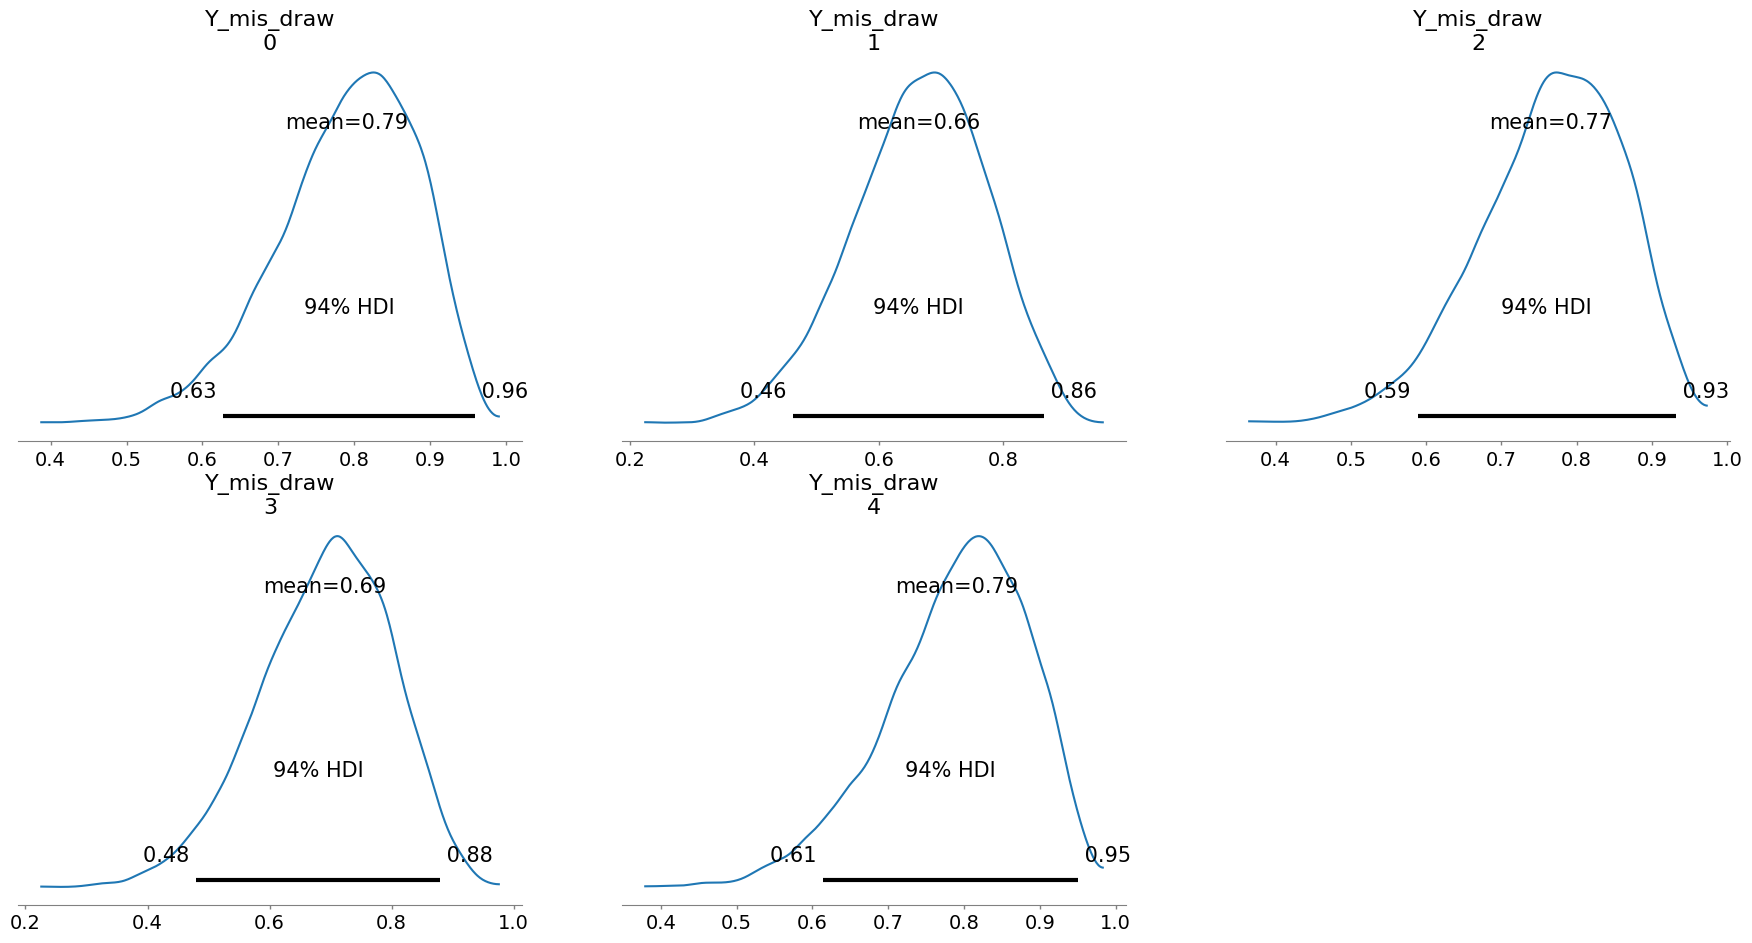

In [89]:
az.plot_posterior(idata.posterior_predictive, var_names=["Y_mis_draw"], coords={"Y_mis_draw_dim_0": slice(0, 4)})

In [90]:
D, dfs = 100, []
mis_idx2 = model_data[model_data['Missing'] == 1].index
y_mis_samples = idata.posterior_predictive["Y_mis_draw"].stack(sample=("chain", "draw")).values

rng = np.random.default_rng(seed=123)
n_samples = y_mis_samples.shape[1]

for _ in range(0, D):
    rand_idx = rng.integers(low=0, high=n_samples, size=y_mis_samples.shape[0])
    y_mis_draw = y_mis_samples[np.arange(y_mis_samples.shape[0]), rand_idx]
    new_df = model_data.copy()
    new_df.loc[mis_idx2, 'Grade'] = y_mis_draw
    dfs.append(new_df)

In [91]:
means = []
variances = []

for df in dfs:
    y = df['Grade'].values
    means.append(np.mean(y))
    variances.append(np.var(y, ddof=1) / len(y))

Q_bar = np.mean(means)
U_bar = np.mean(variances)
B = np.var(means, ddof=1)
T = U_bar + (1 + 1/D) * B

# Step 3: Degrees of freedom
df_denom = ((1 + 1/D) * B)
df = (D - 1) * (1 + U_bar / df_denom) ** 2

# Step 4: 95% Confidence Interval
alpha = 0.05
t_crit = t.ppf(1 - alpha / 2, df)   # force scalar
ci_lower = Q_bar - t_crit * np.sqrt(T)
ci_upper = Q_bar + t_crit * np.sqrt(T)

print(f"Combined Mean Estimate: {Q_bar:.4f}")
print(f"95% CI: ({ci_lower:.4f}, {ci_upper:.4f})")

Combined Mean Estimate: 0.6600
95% CI: (0.6502, 0.6698)


In [92]:
x = mnar[mnar['Missing'] == 0]['Grade'].values
n = len(x)
mnar_mean = np.mean(x)
mnar_se = np.std(x, ddof=1) / np.sqrt(n)
t_crit = t.ppf(1 - alpha / 2, df=n - 1)

ci_lower = mnar_mean - t_crit * mnar_se
ci_upper = mnar_mean + t_crit * mnar_se
print(f'Mean: {mnar_mean:.4f} CI L: {ci_lower:.4f} CI U: {ci_upper:.4f})')

Mean: 0.6338 CI L: 0.6225 CI U: 0.6451)


In [93]:
x = mnar['Grade'].values
n = len(x)
mean = np.mean(x)
se = np.std(x, ddof=1) / np.sqrt(n)
t_crit = t.ppf(1 - alpha / 2, df=n - 1)

ci_lower = mean - t_crit * se
ci_upper = mean + t_crit * se
print(f'Mean: {mean:.4f} CI L: {ci_lower:.4f} CI U: {ci_upper:.4f})')

Mean: 0.6655 CI L: 0.6568 CI U: 0.6742)


In [94]:
print(f'MNAR Difference: {mean - mnar_mean:.3f} \t Relative Difference: {(mean - mnar_mean) / mean:.3f}')
_, p_value = ttest_1samp(mnar[mnar['Missing'] == 0]['Grade'].values, popmean=mean)
print(f"MNAR p-value = {p_value:.3f}\n")

print(f'MI Difference: {mean - Q_bar:.3f} \t Relative Difference: {(mean - Q_bar) / mean:.3f}')
t_stat = (Q_bar - mean) / np.sqrt(T)
p_value = 2 * t.sf(np.abs(t_stat), df)
print(f"MI p-value: {p_value:.3f}")

MNAR Difference: 0.032 	 Relative Difference: 0.048
MNAR p-value = 0.000

MI Difference: 0.005 	 Relative Difference: 0.008
MI p-value: 0.275


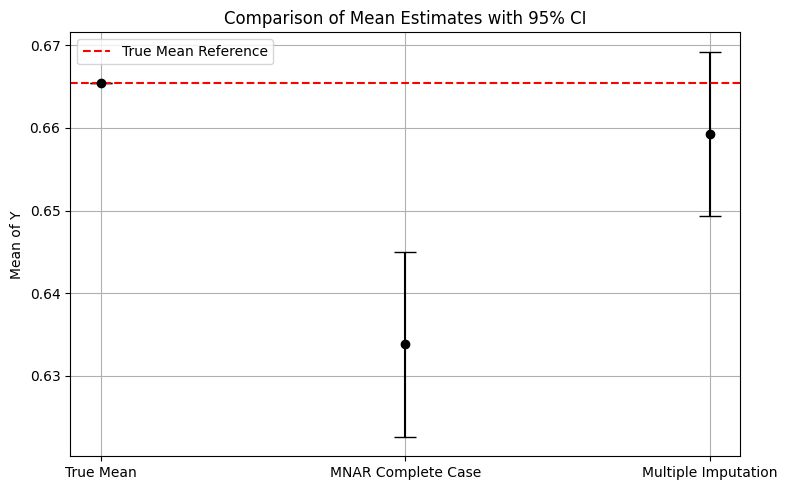

In [79]:
ci_cc = 1.96 * mnar_se  # Approximate 95% CI for CC
ci_mi = 1.96 * np.sqrt(T)  # Approximate CI for MI (or use t-crit with df)

means = [mean, mnar_mean, Q_bar]
errors = [0, ci_cc, ci_mi]  # no error for true mean

labels = ['True Mean', 'MNAR Complete Case', 'Multiple Imputation']

plt.figure(figsize=(8, 5))
plt.errorbar(x=labels, y=means, yerr=errors, fmt='o', capsize=8, color='black')
plt.axhline(mean, linestyle='--', color='red', label='True Mean Reference')
plt.ylabel("Mean of Y")
plt.title("Comparison of Mean Estimates with 95% CI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

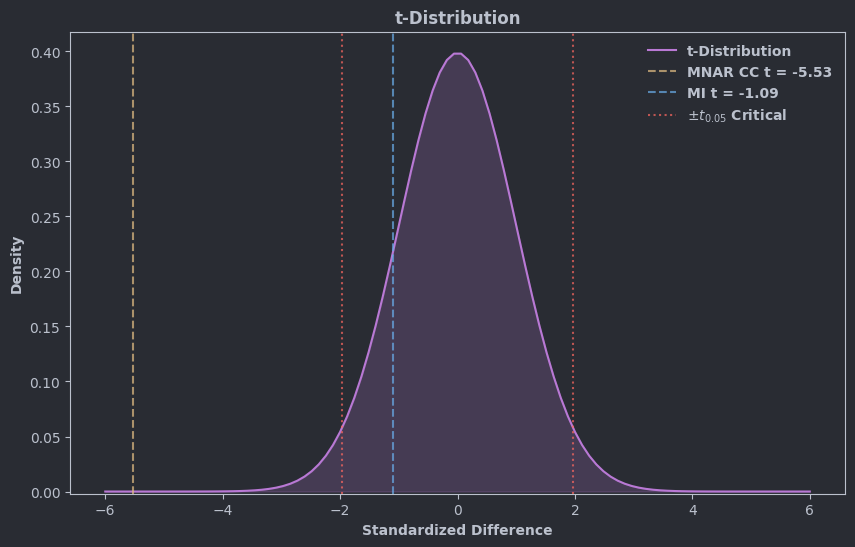

In [95]:
# Differences and t-scores
delta_cc = mnar_mean - mean
delta_mi = Q_bar - mean

t_cc = delta_cc / mnar_se
t_mi = delta_mi / np.sqrt(T)

x = np.linspace(-6, 6, 100)
pdf_cc = t.pdf(x, len(mnar[mnar['Missing'] == 0]) - 1)
pdf_mi = t.pdf(x, df)

alpha = 0.05
t_crit_cc = t.ppf(1 - alpha/2, df=len(mnar[mnar['Missing'] == 0]) - 1)

# Set background color for the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#292C33')  # Background color for figure
ax.set_facecolor('#292C33')  # Background color for the plot area

# Actual data plotting
plt.plot(x, pdf_cc, color='#B979D5', label='t-Distribution')
plt.fill_between(x, pdf_cc, color='#B979D5', alpha=0.2)

# Add vertical lines for actual t-values
plt.axvline(t_cc, linestyle='--', color='#E4BE83', alpha=0.7, label=f'MNAR CC t = {t_cc:.2f}')
plt.axvline(t_mi, linestyle='--', color='#6AADE9', alpha=0.7, label=f'MI t = {t_mi:.2f}')

# Customize axis lines and text
ax.spines['bottom'].set_color('#BBC1CD')  # Bottom axis color
ax.spines['left'].set_color('#BBC1CD')  # Left axis color
ax.spines['right'].set_color('#BBC1CD')  # Left axis color
ax.spines['top'].set_color('#BBC1CD')  # Left axis color
ax.tick_params(axis='x', colors='#BBC1CD')  # X-axis tick color
ax.tick_params(axis='y', colors='#BBC1CD')  # Y-axis tick color

plt.axvline(t_crit_cc, color='#FF6961', linestyle=':', alpha=0.7, label=r'$\pm t_{0.05}$ Critical')
plt.axvline(-t_crit_cc, color='#FF6961', linestyle=':', alpha=0.7)

# Labels and title
plt.xlabel('Standardized Difference', color='#BBC1CD', fontweight='bold')
plt.ylabel('Density', color='#BBC1CD', fontweight='bold')
plt.title('t-Distribution', color='#BBC1CD', fontweight='bold')

# Add a legend
legend = ax.legend(facecolor='#292C33', framealpha=0, edgecolor='#000000', prop={'weight': 'bold'})
ax.set_ylim(bottom=-0.002)

# Change legend text color
for text in legend.get_texts():
    text.set_color('#BBC1CD')  # Set the legend text color to black

plt.savefig('Grade_MNAR_CC_MI_t-distribution_plot.svg', format='svg', dpi=1200)

plt.show()